## Import Libraries & DataSet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import os
import pickle


from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf

warnings.filterwarnings('ignore')

## Load Train & Test DATASET

In [6]:
train_data = pd.read_csv('train.csv', encoding='latin1')
test_data = pd.read_csv('test.csv', encoding='latin1')

In [5]:
#Max Columns & Rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
#CONCATENATE DATASET
df = pd.concat([train_data, test_data])

In [8]:
#DISPLAY DATASET
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


## Data PreProcessing

In [11]:
#Removing Unnecessary Charactors
def remove_unnecessary_characters(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

In [12]:
df['clean_text'] = df['text'].apply(remove_unnecessary_characters)

In [13]:
#TOKENIZATION

from nltk.tokenize import word_tokenize
def tokenize_text(text):
    try:
        text = str(text)
        tokens = word_tokenize(text)
        return tokens
    except Exception as e:
        print(f"Error tokenizing text: {e}")
        return []
df['tokens'] = df['text'].apply(tokenize_text)

In [15]:
#Data Normalization

def normalize_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text

df['normalized_text'] = df['clean_text'].apply(normalize_text)

In [16]:
#Removing Stopwords

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_text = ' '.join(filtered_words)
    else:
        filtered_text = ''
    return filtered_text

df['text_without_stopwords'] = df['normalized_text'].apply(remove_stopwords)

## EDA

In [17]:
# Display a few examples of the cleaned text
print(df[['text', 'text_without_stopwords']].head())

                                                text  \
0                I`d have responded, if I were going   
1      Sooo SAD I will miss you here in San Diego!!!   
2                          my boss is bullying me...   
3                     what interview! leave me alone   
4   Sons of ****, why couldn`t they put them on t...   

                     text_without_stopwords  
0                        id responded going  
1                   sooo sad miss san diego  
2                             boss bullying  
3                     interview leave alone  
4  sons couldnt put releases already bought  


In [18]:
#Removing Missing Values
df.dropna(inplace=True)

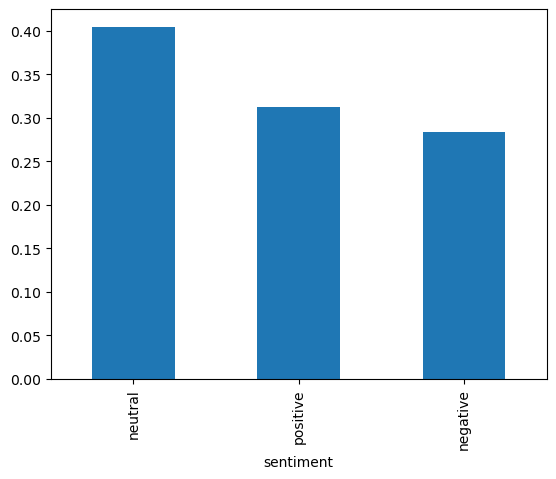

In [19]:
#SENTIMENT VALUECOUNTS
df['sentiment'].value_counts(normalize=True).plot(kind='bar');

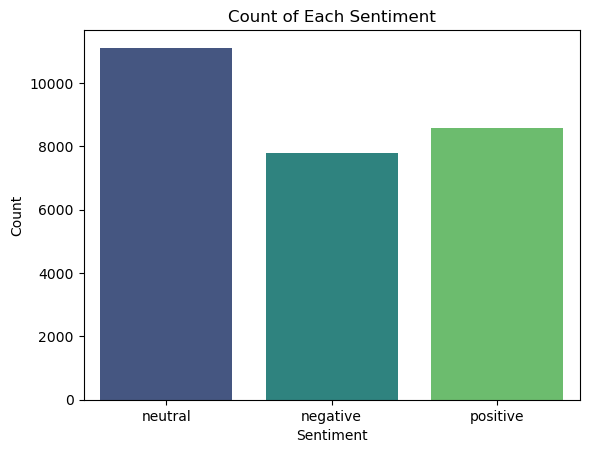

In [20]:
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title('Count of Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

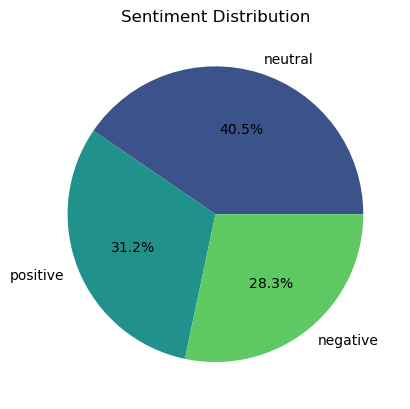

In [21]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('viridis', len(df['sentiment'].unique())))
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

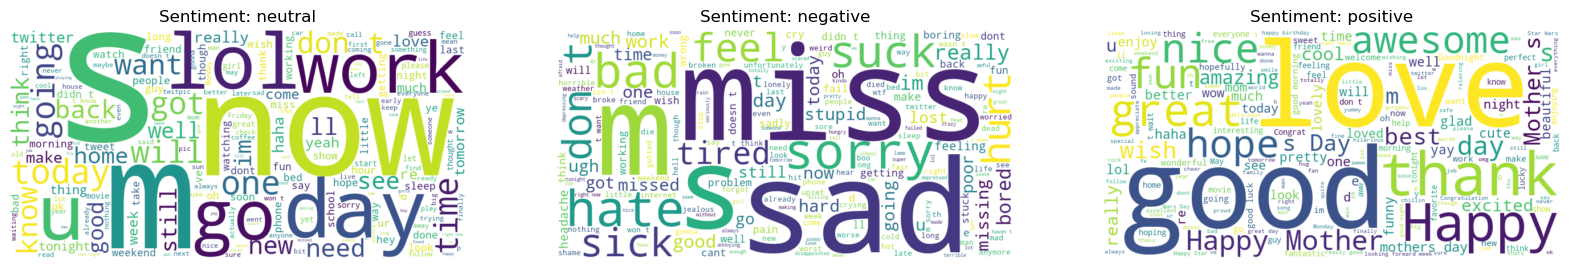

In [25]:
from wordcloud import WordCloud

sentiments = df['sentiment'].unique()
plt.figure(figsize=(20, 10))
for i, sentiment in enumerate(sentiments):
    plt.subplot(1, len(sentiments), i+1)
    text = ' '.join(df[df['sentiment'] == sentiment]['selected_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Sentiment: {sentiment}')
plt.show()

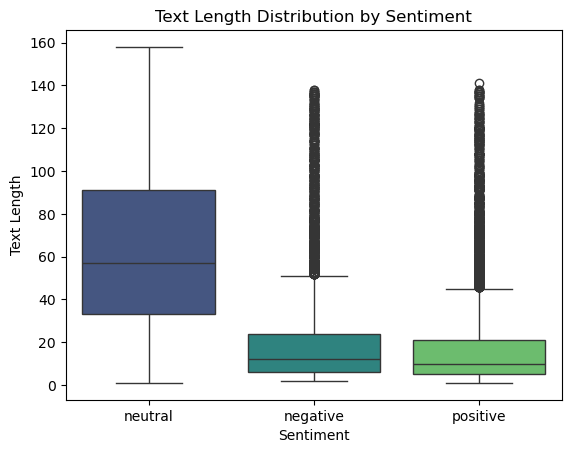

In [23]:
df['text_length'] = df['selected_text'].apply(len)
sns.boxplot(data=df, x='sentiment', y='text_length', palette='viridis')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

In [26]:
df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

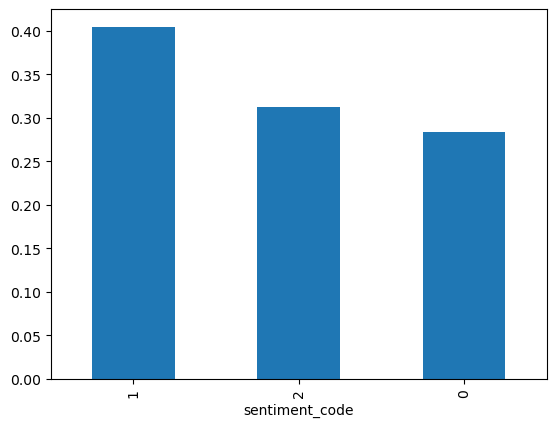

In [27]:
#CATEGORIZATION

df['sentiment_code'] = df['sentiment'].astype('category').cat.codes
sentiment_distribution = df['sentiment_code'].value_counts(normalize=True)
sentiment_distribution.plot(kind='bar')
plt.show()

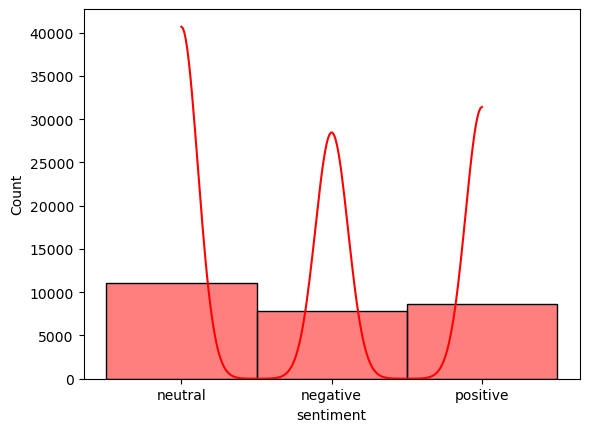

In [28]:
#Visualization Using Histplot

sns.histplot(df['sentiment'], kde=True, color = 'r')
plt.show()

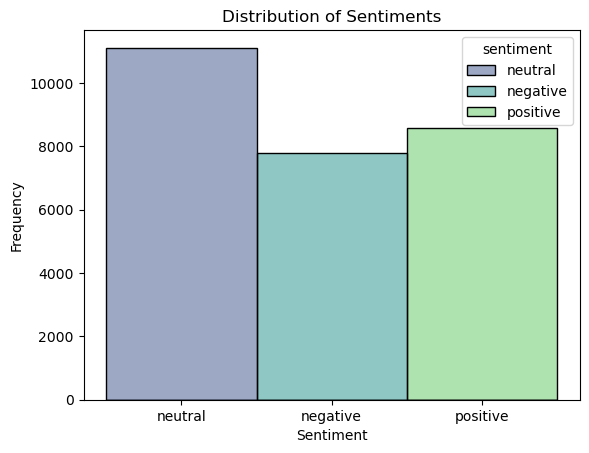

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette
palette = sns.color_palette('viridis', n_colors=3)

# Plot histogram with different colors for each sentiment
sns.histplot(data=df, x='sentiment', hue='sentiment', kde=True, palette=palette)

plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

In [30]:
df['text_length'] = df['selected_text'].apply(len)

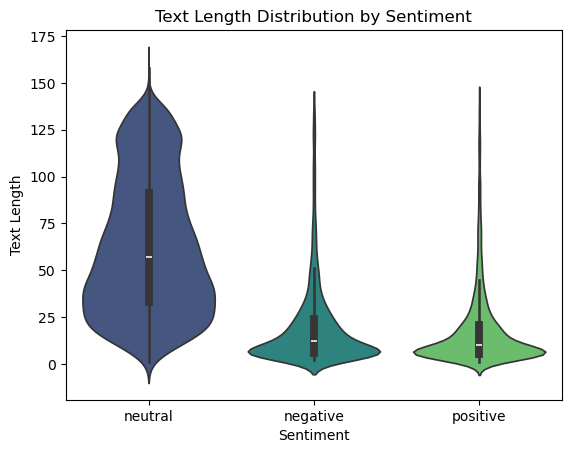

In [31]:
#Violin Plot of Text Length by Sentiment

sns.violinplot(data=df, x='sentiment', y='text_length', palette='viridis')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

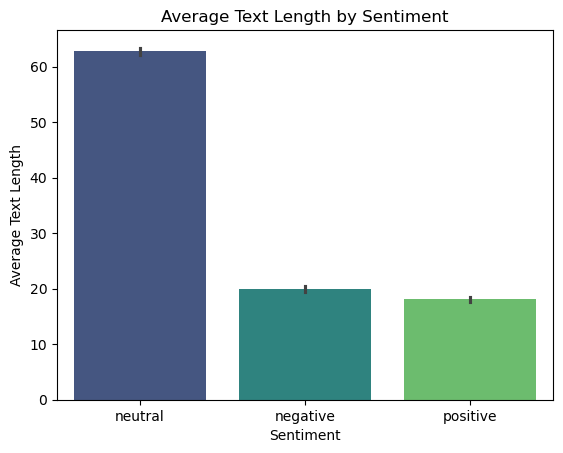

In [32]:
#Bar Plot of Sentiments with Text Length

sns.barplot(data=df, x='sentiment', y='text_length', palette='viridis')
plt.title('Average Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Text Length')
plt.show()

In [33]:
#Stems Words Using the Lancaster Stemmer

from nltk.stem import LancasterStemmer
from string import punctuation
stuff_to_be_removed = list(stopwords.words('english')) + list(punctuation)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[10])

27480
 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff


In [34]:
#Word Frequency Distribution

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

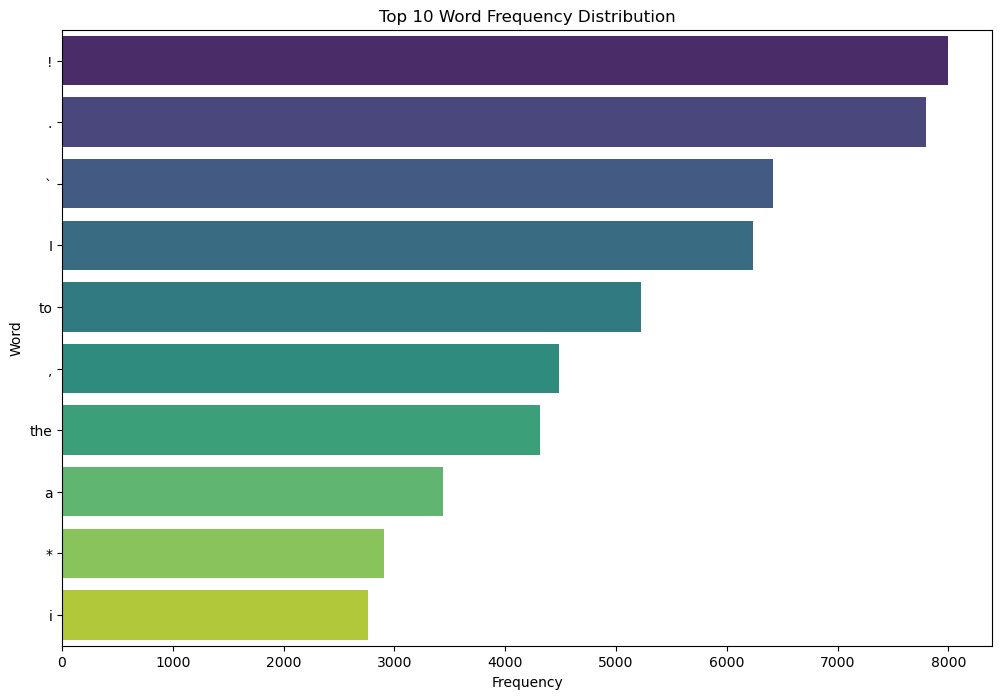

In [35]:
# Tokenize the words
all_words = word_tokenize(' '.join(df['selected_text']))

# Get the frequency distribution
word_freq = FreqDist(all_words)

# Convert the frequency distribution to a DataFrame
word_freq_df = pd.DataFrame(word_freq.most_common(10), columns=['Word', 'Frequency'])

# Create a seaborn barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='viridis')

plt.title('Top 10 Word Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

In [36]:
#CONVERT To Strings

final_corpus = df['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [37]:
print(df.columns)

Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)', 'clean_text', 'tokens', 'normalized_text',
       'text_without_stopwords', 'text_length', 'sentiment_code'],
      dtype='object')


In [38]:
df['Time of Tweet'] = df['Time of Tweet'].astype('category').cat.codes
df['Country'] = df['Country'].astype('category').cat.codes
df['Age of User']=df['Age of User'].replace({'0-20':18,'21-30':25,'31-45':38,'46-60':53,'60-70':65,'70-100':80})

In [39]:
#Removing Irrelevent Columns

df=df.drop(columns=['textID','Time of Tweet', 'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)'])

In [40]:
#PREPROCESS TEXT

import string
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['selected_text'] = df["selected_text"].apply(wp)
df.head()

,text,selected_text,sentiment,clean_text,tokens,normalized_text,text_without_stopwords,text_length,sentiment_code
0,"I`d have responded, if I were going",Id have responded if I were going,neutral,Id have responded if I were going,"[I, `, d, have, responded, ,, if, I, were, going]",id have responded if i were going,id responded going,35,1
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego,"[Sooo, SAD, I, will, miss, you, here, in, San,...",sooo sad i will miss you here in san diego,sooo sad miss san diego,8,0
2,my boss is bullying me...,bullying me,negative,my boss is bullying me,"[my, boss, is, bullying, me, ...]",my boss is bullying me,boss bullying,11,0
3,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[what, interview, !, leave, me, alone]",what interview leave me alone,interview leave alone,14,0
4,"Sons of ****, why couldn`t they put them on t...",Sons of,negative,Sons of why couldnt they put them on the relea...,"[Sons, of, *, *, *, *, ,, why, couldn, `, t, t...",sons of why couldnt they put them on the relea...,sons couldnt put releases already bought,13,0


In [41]:
df.tail()

,text,selected_text,sentiment,clean_text,tokens,normalized_text,text_without_stopwords,text_length,sentiment_code
27476,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on Denver husband los...,"[wish, we, could, come, see, u, on, Denver, hu...",wish we could come see u on denver husband los...,wish could come see u denver husband lost job ...,6,0
27477,I`ve wondered about rake to. The client has ...,dont force,negative,Ive wondered about rake to The client has made...,"[I, `, ve, wondered, about, rake, to, ., The, ...",ive wondered about rake to the client has made...,ive wondered rake client made clear net dont f...,13,0
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you,positive,Yay good for both of you Enjoy the break you p...,"[Yay, good, for, both, of, you, ., Enjoy, the,...",yay good for both of you enjoy the break you p...,yay good enjoy break probably need hectic week...,25,2
27479,But it was worth it ****.,But it was worth it,positive,But it was worth it,"[But, it, was, worth, it, *, *, *, *, .]",but it was worth it,worth,26,2
27480,All this flirting going on - The ATG smiles...,All this flirting going on The ATG smiles Yay...,neutral,All this flirting going on The ATG smiles Yay ...,"[All, this, flirting, going, on, -, The, ATG, ...",all this flirting going on the atg smiles yay ...,flirting going atg smiles yay hugs,58,1


In [42]:
#Balance the Dataset

# Separate classes
df_neutral = df[df['sentiment'] == 'neutral']
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']

# Upsample minority classes
df_positive_upsampled = resample(df_positive, replace=True, n_samples=len(df_neutral), random_state=123)
df_negative_upsampled = resample(df_negative, replace=True, n_samples=len(df_neutral), random_state=123)

# Combine the dataframes
df_balanced = pd.concat([df_neutral, df_positive_upsampled, df_negative_upsampled])
print(df_balanced['sentiment'].value_counts())

label_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
df_balanced['label'] = df_balanced['sentiment'].map(label_mapping)

sentiment
neutral     11117
positive    11117
negative    11117
Name: count, dtype: int64


## Model Selection

In [43]:
#Split the dataset

from sklearn.model_selection import train_test_split
X=df['selected_text']
y= df['sentiment']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['text_without_stopwords'], df_balanced['label'], test_size=0.2, random_state=42)

In [45]:
#Creating TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [49]:
score_baseline = df['sentiment'].value_counts(normalize=True).max()
score_baseline

0.40454876273653567

In [47]:
#Train the SVM model

from sklearn.svm import SVC
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_tfidf, y_train)

SVC(kernel='linear', probability=True)

In [48]:
#Evaluate the model

y_pred = svm.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')

Accuracy: 0.7394693449257982
F1 Score: 0.7410589111637804


In [50]:
#Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2229
           1       0.82      0.79      0.80      2244
           2       0.78      0.73      0.75      2198

    accuracy                           0.74      6671
   macro avg       0.74      0.74      0.74      6671
weighted avg       0.74      0.74      0.74      6671



## Evaluation Metrics

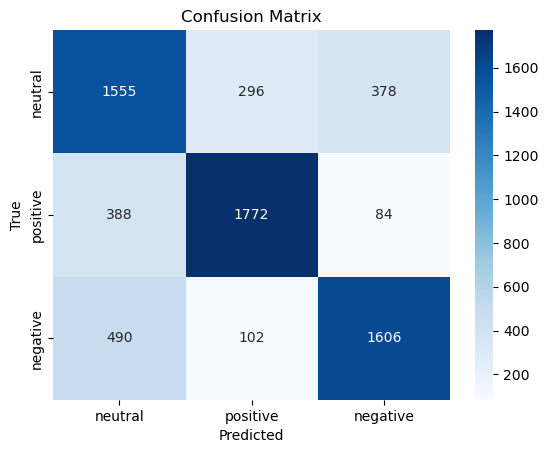

In [51]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
#Save the model and vectorizer

model_path = 'svm_model.pkl'
vectorizer_path = 'tfidf_vectorizer.pkl'

with open(model_path, 'wb') as file:
    pickle.dump(svm, file)

with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

In [53]:
#Load the model and vectorizer

with open(model_path, 'rb') as file:
    svm = pickle.load(file)

with open(vectorizer_path, 'rb') as file:
    vectorizer = pickle.load(file)

## Testing

In [54]:
#Manual testing function

def output_label(n):
    if n == 0:
        return "The Text Sentiment is Neutral"
    elif n == 1:
        return "The Text Sentiment is Positive"
    elif n == 2:
        return "The Text Sentiment is Negative"

def manual_testing(text):
    # Clean and preprocess the input text
    text = remove_unnecessary_characters(text)
    text = normalize_text(text)
    text = remove_stopwords(text)
    text_tfidf = vectorizer.transform([text])
    prediction = svm.predict(text_tfidf)[0]
    return output_label(prediction)

In [55]:
#Test manual testing function

text = "I`d have responded, if I were going "
result = manual_testing(text)
print(result)

The Text Sentiment is Neutral


In [57]:
text = "Received a promotion at work today! Feeling grateful and excited for the new opportunities ahead."
result = manual_testing(text)
print(result)

The Text Sentiment is Positive


In [58]:
text = "I just finished watching my favorite movie, and it was absolutely fantastic!"
result = manual_testing(text)
print(result)

The Text Sentiment is Positive


In [59]:
text = "Today's weather is perfect for a picnic in the park with friends and family."
result = manual_testing(text)
print(result)

The Text Sentiment is Positive


In [60]:
text = "Sooo SAD I will miss you here in San Diego!! "
result = manual_testing(text)
print(result)

The Text Sentiment is Negative


In [61]:
text = "Stuck in traffic again! This commute is never-ending."
result = manual_testing(text)
print(result)

The Text Sentiment is Negative


In [62]:
text ="Feeling frustrated after waiting in line for an hour, only to find out the item I wanted is out of stock."
result = manual_testing(text)
print(result)


The Text Sentiment is Negative


In [63]:
text ="Received disappointing news about a project I've been working on for months. Feeling demotivated. "
result = manual_testing(text)
print(result)

The Text Sentiment is Negative


In [64]:
text = "Just finished my morning coffee and ready to start the day."
result = manual_testing(text)
print(result)

The Text Sentiment is Neutral


In [65]:
text = "Just missed my morning coffee and feeling lazy to start the day."
result = manual_testing(text)
print(result)

The Text Sentiment is Negative
